In [64]:
import pandas as pd
import numpy as np
from common import collect_results, normalize_region_name
from pathlib import Path
from matplotlib import pyplot as plt

In [65]:
ROOT = Path("./ycsb")

def get_matcher(prefix):
    def matcher(p: Path):   
        import re
        pattern = re.compile(prefix + r"-hot(\d+)-(\w)-mr(\d+)-([\d-]+)")
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        hot = int(match.group(1))
        return {
            "hot": 1000000 if hot == 0 else hot,
            "workload": str(match.group(2)),
            "mr": int(match.group(3)),
            "suffix": str(match.group(4)),
        }
    
    return matcher

# Throughput


In [66]:
SYSTEMS = ["sunstorm", "aurora-global", "aurora-eventual", "yugabyte", "cockroach"]
# SYSTEMS = ["sunstorm", "aurora", "yugabyte"]
HOTS = [100000, 1000]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("ycsb-throughput-sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "throughput-sunstorm-serializable",
    sunstorm_matcher,
    RENEW_CACHE,
)
sunstorm_throughput_df["system"] = "sunstorm"

# sunstorm_matcher = get_matcher("ycsb-throughput-sunstorm")
# sunstorm_serializable_throughput_df = collect_results(
#     ROOT / "throughput-sunstorm-serializable",
#     sunstorm_matcher,
#     RENEW_CACHE,
# )
# sunstorm_serializable_throughput_df["system"] = "sunstorm-serializable"


aurora_matcher = get_matcher("ycsb-throughput-aurora")
aurora_throughput_df = collect_results(
    ROOT / "throughput-aurora",
    aurora_matcher,
    RENEW_CACHE,
)
# aurora_throughput_df["system"] = "aurora"
aurora_throughput_df["system"] = "aurora-global"

aurora_matcher = get_matcher("ycsb-throughput-aurora")
aurora_eventual_throughput_df = collect_results(
    ROOT / "throughput-aurora-eventual",
    aurora_matcher,
    RENEW_CACHE,
)
aurora_eventual_throughput_df["system"] = "aurora-eventual"


yugabyte_matcher = get_matcher("ycsb-throughput-yugabyte")
yugabyte_throughput_df = collect_results(
    ROOT / "throughput-yugabyte",
    yugabyte_matcher,
    RENEW_CACHE,
)
yugabyte_throughput_df["system"] = "yugabyte"

cockroach_matcher = get_matcher("ycsb-throughput-cockroach")
cockroach_throughput_df = collect_results(
    ROOT / "throughput-cockroach",
    cockroach_matcher,
    RENEW_CACHE,
)
cockroach_throughput_df["system"] = "cockroach"

In [67]:
throughput_df = pd.concat([
    sunstorm_throughput_df,
    aurora_throughput_df,
    aurora_eventual_throughput_df,
    yugabyte_throughput_df,
    cockroach_throughput_df,
])
throughput_df["HOT"] = throughput_df["hot"]
throughput_df["workload"] = "100% Writes"
normalize_region_name(throughput_df)
# throughput_df.rename(columns={"other_aborts": "pg_aborts"}, inplace=True)
throughput_df

,path,region,hot,workload,mr,suffix,rejected,rejected.WorkloadF1,rejected.WorkloadF2,rejected.WorkloadF3,...,p50,p75,p90,p95,p99,p100,throughput,system,unexpected.WorkloadF1,HOT
0,ycsb/throughput-sunstorm-serializable/ycsb-thr...,1-us-east-1-0,1000,100% Writes,5,20241222-102401,58589,24464,27813.0,6312.0,...,4.927,5.6020,6.5140,7.92000,289.98012,872.791,3472.070659,sunstorm,NaN,1000
1,ycsb/throughput-sunstorm-serializable/ycsb-thr...,3-ap-northeast-1-0,1000,100% Writes,5,20241222-102401,52762,27787,19515.0,5460.0,...,3.905,4.4690,5.4770,7.17800,444.34116,920.487,3184.672044,sunstorm,NaN,1000
2,ycsb/throughput-sunstorm-serializable/ycsb-thr...,2-eu-west-1-0,1000,100% Writes,5,20241222-102401,55810,30879,18789.0,6142.0,...,4.360,5.0740,6.2010,8.67300,377.55625,1056.814,3630.031150,sunstorm,NaN,1000
3,ycsb/throughput-sunstorm-serializable/ycsb-thr...,1-us-east-1-0,100000,100% Writes,5,20241222-102401,2664,1955,588.0,121.0,...,5.585,6.2630,7.4330,82.15835,170.96600,512.667,7658.091210,sunstorm,NaN,100000
4,ycsb/throughput-sunstorm-serializable/ycsb-thr...,3-ap-northeast-1-0,100000,100% Writes,5,20241222-102401,3125,2124,829.0,172.0,...,4.497,5.0100,5.9070,156.10500,218.70000,656.406,6527.727427,sunstorm,NaN,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,ycsb/throughput-cockroach/ycsb-throughput-cock...,3-ap-northeast-1-0,100000,100% Writes,0,20241126-225357,318,318,NaN,NaN,...,173.095,217.3065,261.1536,289.60130,346.91918,705.764,2924.094151,cockroach,NaN,100000
26,ycsb/throughput-cockroach/ycsb-throughput-cock...,2-eu-west-1-0,100000,100% Writes,0,20241126-225357,314,314,NaN,NaN,...,192.203,240.0950,288.5768,319.64380,384.64144,661.618,2647.337690,cockroach,NaN,100000
27,ycsb/throughput-cockroach/ycsb-throughput-cock...,1-us-east-1-0,1000,100% Writes,0,20241126-225357,5460,5460,NaN,NaN,...,164.236,211.3470,268.6430,311.02400,393.54720,700.446,2844.069269,cockroach,NaN,1000
28,ycsb/throughput-cockroach/ycsb-throughput-cock...,3-ap-northeast-1-0,1000,100% Writes,0,20241126-225357,5648,5648,NaN,NaN,...,161.854,208.3470,264.9124,306.00610,388.02994,629.192,2888.995681,cockroach,NaN,1000


In [68]:
throughput_df[throughput_df.hot.isin(HOTS)].pivot_table(
        index=["mr"], columns=["system", "hot"], values="throughput", aggfunc="sum"
    )

system aurora-eventual              aurora-global                 cockroach  \
hot             1000         100000        1000         100000       1000     
mr                                                                            
0          7188.644519  8340.211495   5557.893951  8136.383050  8366.341201   
5          7005.752573  8261.841744   4400.017019  8316.723709  6669.451389   
10         6823.702652  8175.183799   4297.631773  8301.542617  4659.430068   
15         6746.853981  8269.749196   4250.509137  8265.765243  3505.459761   
50         6270.865167  8277.919247   2934.445572  8394.734755  1257.129989   

system                   sunstorm                   yugabyte               
hot          100000        1000          100000       1000         100000  
mr                                                                         
0       8530.942822  32045.419437  32249.699629  5697.428945  7161.714853  
5       8074.753354  10286.773852  21393.237255  5055.982264  6615.263382  
10      7395.650643   7041.053484  13988.520601  4541.135471  6194.688151  
15      6381.096594   4477.457508  10282.883783  4040.932272  5777.051935  
50      2367.329698   1086.178761   4767.009548  1863.308494  3055.809646

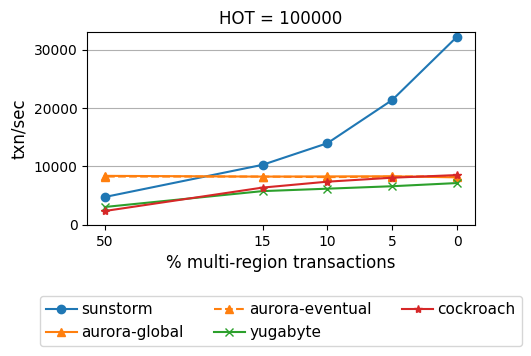

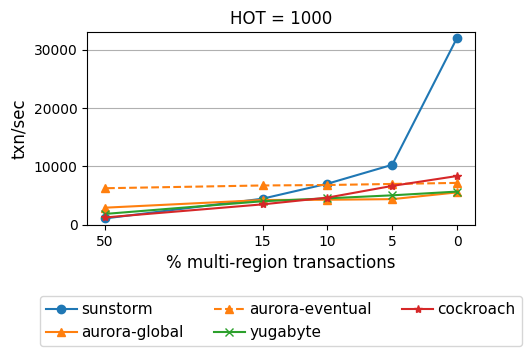

In [69]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for hot in HOTS:
    hot_df = throughput_df[throughput_df.hot == hot]
    hot_label = hot
    # Print hot_df when "mr" is 0
    ax = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="throughput", aggfunc="sum"
    )[SYSTEMS].plot(
        title=f"HOT = {hot_label}",
        xlabel="% multi-region transactions",
        ylabel="txn/sec",
        figsize=(5, 2.5),
        style=["o-", "^-", "^--", "x-", "*-"],
        color=["C0", "C1", "C1", "C2", "C3"],
        ylim=(0, 33000),
        rot=0,
    )
    ax.set_xscale("symlog", linthresh=20)
    ax.set_xticks([0, 5, 10, 15, 50])
    ax.set_xticklabels([0, 5, 10, 15, 50])
    ax.margins(x=0.05)
    ax.grid(axis="y")
    ax.legend(title="", ncol=3, handletextpad=0.3, bbox_to_anchor=(0.5, -0.5), loc="center")
    ax.invert_xaxis()
    #plt.savefig(f"output/micro-throughput-hot{hot}.pdf", bbox_inches="tight")


# Errors


## Single-home

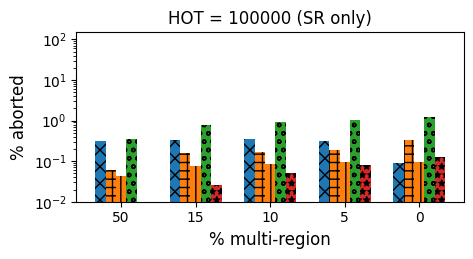

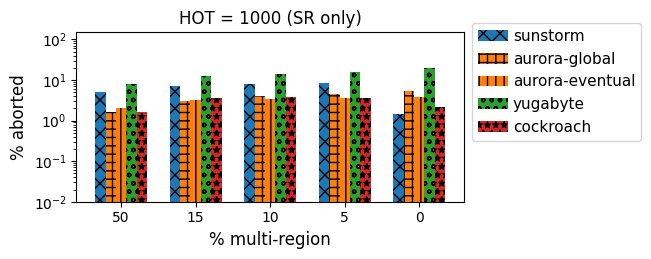

In [70]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for hot in HOTS:
    hot_df = throughput_df[throughput_df.hot == hot]
    aborted_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="rejected.WorkloadF1", aggfunc="sum"
    )
    completed_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="completed", aggfunc="sum"
    )
    ratio_df = aborted_df / (aborted_df + completed_df) * 100

    hot_label = hot
    ax = ratio_df[reversed(SYSTEMS)].plot.bar(
        title=f"HOT = {hot_label} (SR only)",
        xlabel="% multi-region",
        ylabel="% aborted",
        figsize=(5, 2.2),
        rot=0,
        width=0.7,
        color=["C3", "C2", "C1",  "C1", "C0"],
    )
    bars = ax.patches
    patterns = ["**","oo", "||", "++", "xx"]
    hatches = [p for p in patterns for _ in range(len(bars) // len(patterns))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.legend(reversed(legend_handles), reversed(legend_labels), title="", ncol=1, handletextpad=0.3, bbox_to_anchor=(1, 1.1))
    if hot != 1000:
        ax.legend().remove()
    ax.invert_xaxis()
    
    ax.margins(y=0.4)
    # plt.savefig(f"output/micro-abort-sr-hot{hot}.pdf", bbox_inches="tight")

    ax.set_yscale("log")
    ax.set_ylim(0.01, 150)
    # plt.savefig(f"output/micro-abort-sr-hot{hot}-logy.pdf", bbox_inches="tight")

## Multi-Region

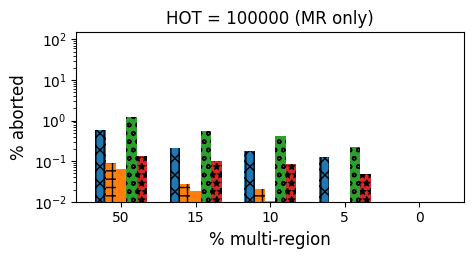

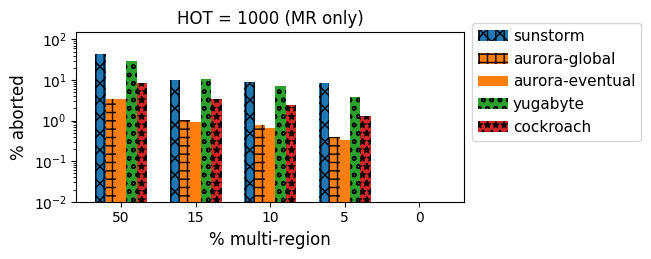

In [71]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for hot in HOTS:
    hot_df = throughput_df[throughput_df.hot == hot]
    rejected_2_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="rejected.WorkloadF2", aggfunc="sum"
    )
    rejected_3_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="rejected.WorkloadF3", aggfunc="sum"
    )
    completed_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="completed", aggfunc="sum"
    )
    aborted_df = rejected_2_df + rejected_3_df
    ratio_df = aborted_df / (aborted_df + completed_df) * 100

    hot_label = hot
    ax = ratio_df[reversed(SYSTEMS)].plot.bar(
        title=f"HOT = {hot_label} (MR only)",
        xlabel="% multi-region",
        ylabel="% aborted",
        figsize=(5, 2.2),
        rot=0,
        width=0.7,
        color=["C3","C2", "C1", "C1", "C0", "C0"],
    )
    bars = ax.patches
    patterns = ["**", "oo", "", "++", "||" "xx"]
    hatches = [p for p in patterns for _ in range(len(bars) // len(patterns))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch, )

    legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.legend(reversed(legend_handles), reversed(legend_labels), title="", ncol=1, handletextpad=0.3, bbox_to_anchor=(1, 1.1))
    if hot != 1000:
        ax.legend().remove()
    ax.invert_xaxis()
    
    ax.margins(y=0.4)
    # plt.savefig(f"output/micro-abort-sr-hot{hot}.pdf", bbox_inches="tight")

    ax.set_yscale("log")
    ax.set_ylim(0.01, 150)
    # plt.savefig(f"output/micro-abort-sr-hot{hot}-logy.pdf", bbox_inches="tight")



## SunStorm error types

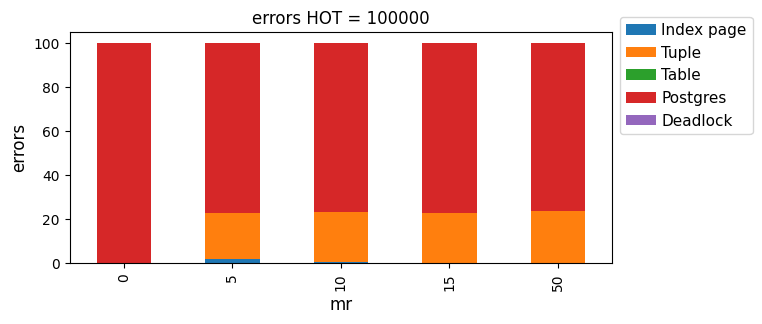

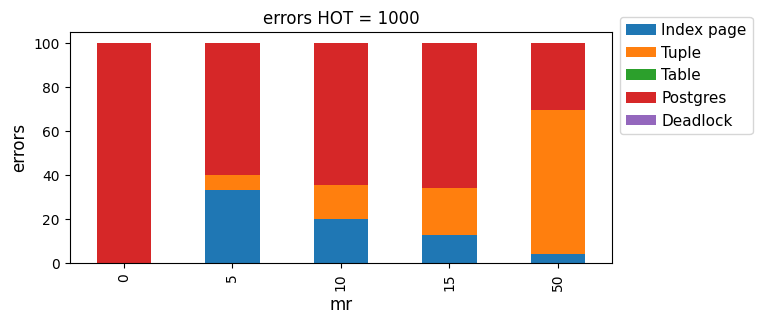

In [72]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

sunstorm_df = throughput_df[throughput_df.system == "sunstorm"]
for hot in HOTS:
    hot_df = sunstorm_df[sunstorm_df.hot == hot]\
        .groupby(["mr"])\
        .sum()
    mh_aborts = hot_df["ood_tuple"] + hot_df["ood_index_page"]  + hot_df["ood_table"] + hot_df["other_aborts"] + hot_df['deadlock']
    hot_df["ood_index_page_pct"] = hot_df["ood_index_page"] / mh_aborts * 100
    hot_df["ood_tuple_pct"] = hot_df["ood_tuple"] / mh_aborts * 100
    hot_df["ood_table_pct"] = hot_df["ood_table"] / mh_aborts * 100
    hot_df["pg_aborts_pct"] = hot_df["other_aborts"] / mh_aborts * 100
    hot_df["deadlock_pct"] = hot_df["deadlock"] / mh_aborts * 100
    ax = hot_df[["ood_index_page_pct", "ood_tuple_pct", "ood_table_pct", "pg_aborts_pct", "deadlock_pct"]].plot.bar( 
        title="errors HOT = " + str(hot),
        ylabel="errors",
        figsize=(7, 3),
        stacked=True,
    )
    ax.legend(["Index page", "Tuple", "Table", "Postgres", "Deadlock"], title="", ncol=1, handletextpad=0.3, bbox_to_anchor=(1, 1.1))

In [78]:
columns = ['ood_index_page', 'ood_tuple', 'other_aborts', 'ood_table', 'deadlock', 'completed'] 
error_df = throughput_df.groupby(["workload","hot", "system", "mr"]).sum()[columns]
error_df["outdated index page"] = error_df["ood_index_page"] / error_df["completed"] * 100
error_df["outdated table"] = error_df["ood_table"] / error_df["completed"] * 100
error_df["outdated tuple"] = error_df["ood_tuple"] / error_df["completed"] * 100
error_df["other aborts"] = error_df["other_aborts"] / error_df["completed"] * 100
error_df["deadlock"] = error_df["deadlock"] / error_df["completed"] * 100
error_df["error_pct"] = error_df["outdated index page"] + error_df["outdated table"] + error_df["outdated tuple"] + error_df["other aborts"] + error_df["deadlock"]
error_df["pct"] = error_df["deadlock"] + error_df["ood_index_page"] + error_df["ood_table"] + error_df["ood_tuple"] + error_df["other_aborts"]

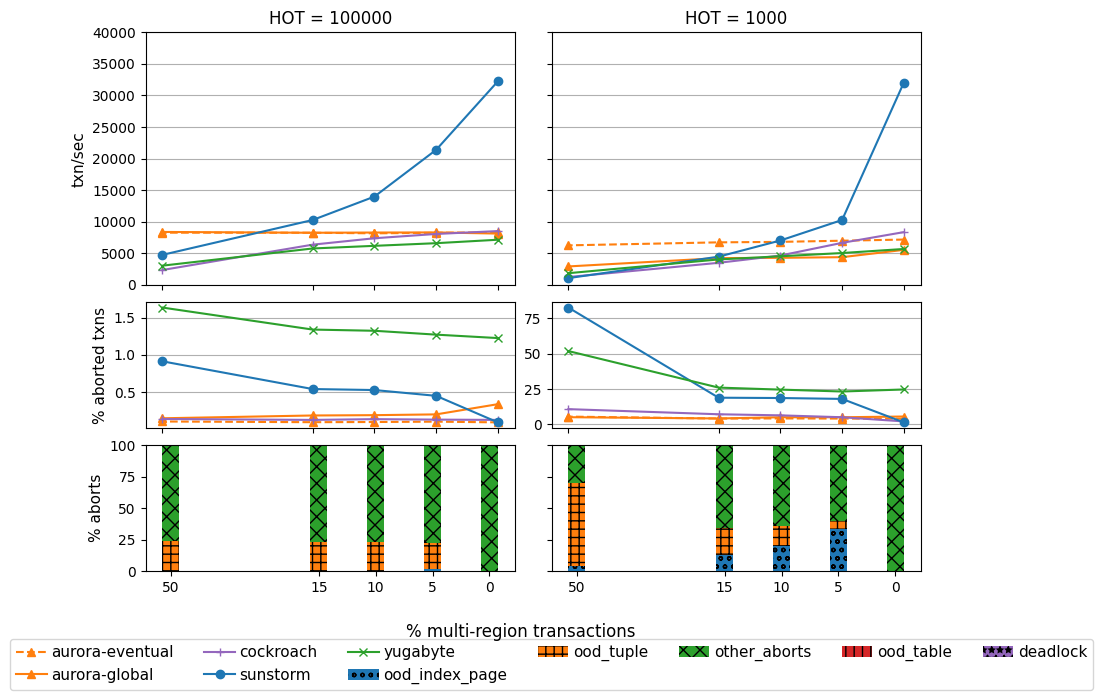

In [79]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

plt.rc('axes', labelsize=11) 
plt.rc('legend', fontsize=11)

xticks = [0, 5, 10, 15, 50]
xticklabels = [0, 5, 10, 15, 50]
legend_handles = []
legend_labels = []
abort_colors = ["C0", "C1", "C2", "C3", "C4"]
abort_patterns = ["oo", "++", "xx", "||", "**"]
error_columns = ['ood_index_page', 'ood_tuple', 'other_aborts', 'ood_table', 'deadlock'] 


fig = plt.figure(figsize=(10, 7))
gs = GridSpec(3, 2, figure=fig, height_ratios=[4, 2, 2], wspace= 0.1, hspace=0.1)

for h,hot in enumerate([100000, 1000]):
    ax = plt.subplot(gs[0, h])
    hot_throughput_df = throughput_df[throughput_df.hot == hot]
    hot_throughput_df.pivot_table(
        index=["mr"], columns=["system"], values="throughput", aggfunc="sum"
    ).plot(
        ax=ax,
        title=f"HOT = {hot}",
        ylabel="txn/sec",
        style=["^--", "^-","+-", "o-", "x-"],
        color=["C1", "C1", "C4", "C0", "C2"],
        ylim=(0, 40000),
        # logy = True,
        rot=0,
        legend=False,
    )
    ax.set_xscale("symlog", linthresh=20)
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    ax.margins(x=0.05)
    ax.grid(axis="y")
    ax.invert_xaxis()
    ax.set_xlabel("")
    
    if h == 1:
        handles, labels = ax.get_legend_handles_labels()
        legend_handles += handles
        legend_labels += labels
        ax.set_yticklabels([])
        ax.set_ylabel("")
    

    ax = plt.subplot(gs[1, h]) 

    error_df.unstack(level=1)["error_pct"].loc["100% Writes"][hot].unstack(level=0)\
        .set_index(np.array(xticks))\
        .plot(
            ax=ax,
            ylabel="% aborted txns",
            style=["^--", "^-","+-", "o-", "x-"],
            color=["C1", "C1", "C4", "C0", "C2"],
            rot=0,
            legend=False,
        )

    ax.set_xscale("symlog", linthresh=20)
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    ax.margins(x=0.05)
    ax.grid(axis="y")
    ax.invert_xaxis()
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    if h == 1:
        ax.set_ylabel("")   

    xticks_hack = [0, 5, 10, 15, 28]
    ax = plt.subplot(gs[2, h])
    sunstorm_error_df = error_df.loc[("100% Writes", hot, "sunstorm",)].copy()
    error_columns_pct = [f"{col}" for col in error_columns]
    bottom = None
    for col, color, pattern in zip(error_columns_pct, abort_colors, abort_patterns):
        error = sunstorm_error_df[col] / sunstorm_error_df["pct"] * 100
        ax.bar(
            xticks_hack,
            error,
            bottom=bottom,
            label=col,
            width=1.5,
            facecolor=color,
            hatch=pattern,
        )
        if bottom is None:
            bottom = error
        else:
            bottom += error
    ax.set_ylim(0, 100)
    ax.margins(x=0.05)
    ax.set_xticks(xticks_hack)
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel("% aborts")
    ax.invert_xaxis()
    if h == 1:
        handles, labels = ax.get_legend_handles_labels()
        legend_handles += handles
        legend_labels += labels
        ax.set_ylabel("")
        ax.set_yticklabels([])

fig.supxlabel("% multi-region transactions")
plt.legend(legend_handles, legend_labels, ncol=7, loc='lower center', handletextpad=0.3,
           bbox_to_anchor=(0,-1)) 


    #plt.savefig(f"output/micro-throughput-hot{hot}.pdf", bbox_inches="tight")
    

# Latency


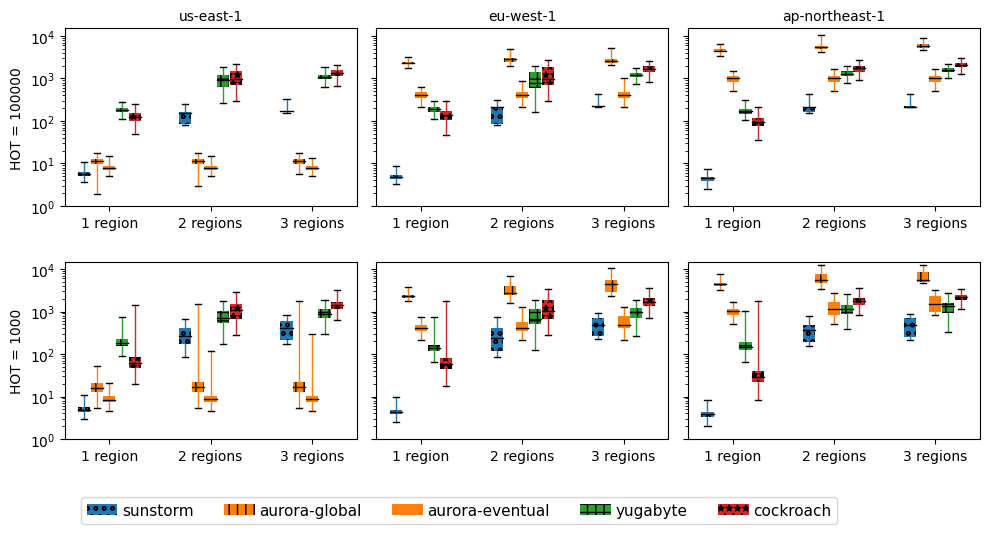

In [82]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 3, figure=fig)

plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

labels = [
    "1 region\n",
    "2 regions\n",
    "3 regions\n",
]
ticks = np.arange(len(labels))

width = 0.5

def to_box(df, n):
    return {
        'whislo': df[f"p0.WorkloadF{n}"].iloc[0],
        'q1': df[f"p25.WorkloadF{n}"].iloc[0],
        'med': df[f"p50.WorkloadF{n}"].iloc[0],
        'q3': df[f"p75.WorkloadF{n}"].iloc[0],
        'whishi': df[f"p99.WorkloadF{n}"].iloc[0],
        'fliers': []
    }

legends = []
patterns = [ "oo", "||", "", "++", "**"]
colors = ["C0", "C1", "C1", "C2", "C3"]

for h, hot in enumerate([100000, 1000]):
    hot_df = throughput_df[throughput_df.hot == hot]
    hot_label = hot
    for r, region in enumerate(["1-us-east-1", "2-eu-west-1", "3-ap-northeast-1"]):
        region_df = hot_df[hot_df.region.str.startswith(region)]

        ax = plt.subplot(gs[h, r])
        for i, system in enumerate(SYSTEMS):
            system_df = region_df[region_df.system == system]
            boxes = [
                to_box(system_df[system_df.mr == 5], 1),
                to_box(system_df[system_df.mr == 5], 2),
                to_box(system_df[system_df.mr == 5], 3),
            ]
            comps = ax.bxp(
                boxes,
                positions=ticks - width / 2 + i * width / (len(SYSTEMS) - 1),
                showfliers=False,
                manage_ticks=False,
                patch_artist=True,
                widths=0.12,
                boxprops={
                    "facecolor": colors[i],
                    "linewidth": 0,
                    "hatch": patterns[i],
                },
                medianprops={
                    "color": "black",
                    "linewidth": 1,
                },
                whiskerprops={
                    "color": colors[i]
                },
            )
            if (h==0 and r==0):
                legends.append(comps["boxes"][0])
            # legends.append(comps["boxes"][0])

        # ax.legend(legends, SYSTEMS, ncol=3)


        ax.set_xticks(labels=labels, ticks=ticks)
        ax.set_yscale("log")
        ax.set_ylim(0.99, 15000)
        # ax.set_ylabel("latency (ms)")
        # ax.grid()
        if h == 0:
            ax.set_title(region[2:], fontsize=10)

        if r == 0:
            ax.set_ylabel(f"HOT = {hot_label}", fontsize=10)
        else:
            ax.set_yticklabels([])
        # ax.set_title(f"HOT = {hot_label} ({region[2:]})")

fig.legend(legends, SYSTEMS, ncol=6, bbox_to_anchor=(0.85, 0.01), handletextpad=0.3)
fig.tight_layout()
fig.savefig("ycsb-latency.pdf", bbox_inches="tight")


In [37]:
def plot_latency(mr, hot):
    # Remove the "-0" suffix in region name
    throughput_df['region'] = throughput_df['region'].str.replace(r'-0', '', regex=True)
    regions = sorted([r for r in set(throughput_df.region.unique()) if not r.endswith("-0")])
    for system in throughput_df.system.unique():
        fig, axes = plt.subplots(1, len(regions), figsize=(20, 4), sharey=True)
        fig.suptitle(f"{system}, hot = {hot}, mr = {mr}%")
        workload_df = throughput_df[
            (throughput_df.system == system)
            & (throughput_df.mr == mr)
            & (throughput_df.hot == hot)
        ]
        # Plot for each region
        for i, region in enumerate(regions):
            region_df = workload_df[workload_df.region.str.startswith(region)]
            if region_df.empty:
                continue
            # Seperate the tran sactions by the number of regions they access
            max_nregion = 3
            index = range(1, max_nregion + 1)
            nregion_latency_df = {
                "p0": [region_df[f"p0.WorkloadF{n}"].iloc[0] for n in index],
                "p25": [region_df[f"p25.WorkloadF{n}"].iloc[0] for n in index],
                "p50": [region_df[f"p50.WorkloadF{n}"].iloc[0] for n in index],
                "p75": [region_df[f"p75.WorkloadF{n}"].iloc[0] for n in index],
                "p95": [region_df[f"p95.WorkloadF{n}"].iloc[0] for n in index],
                "p99": [region_df[f"p99.WorkloadF{n}"].iloc[0] for n in index],
            }
            pd.DataFrame(nregion_latency_df, index=index).plot.bar(
                title=region,
                ylabel="latency (ms)",
                ax=axes[i],
                rot=0,
                ylim=(1, 1200),
                logy=True,
            )
            axes[i].set_xlabel("number of regions")
            axes[i].grid(axis="y")
        plt.tight_layout()

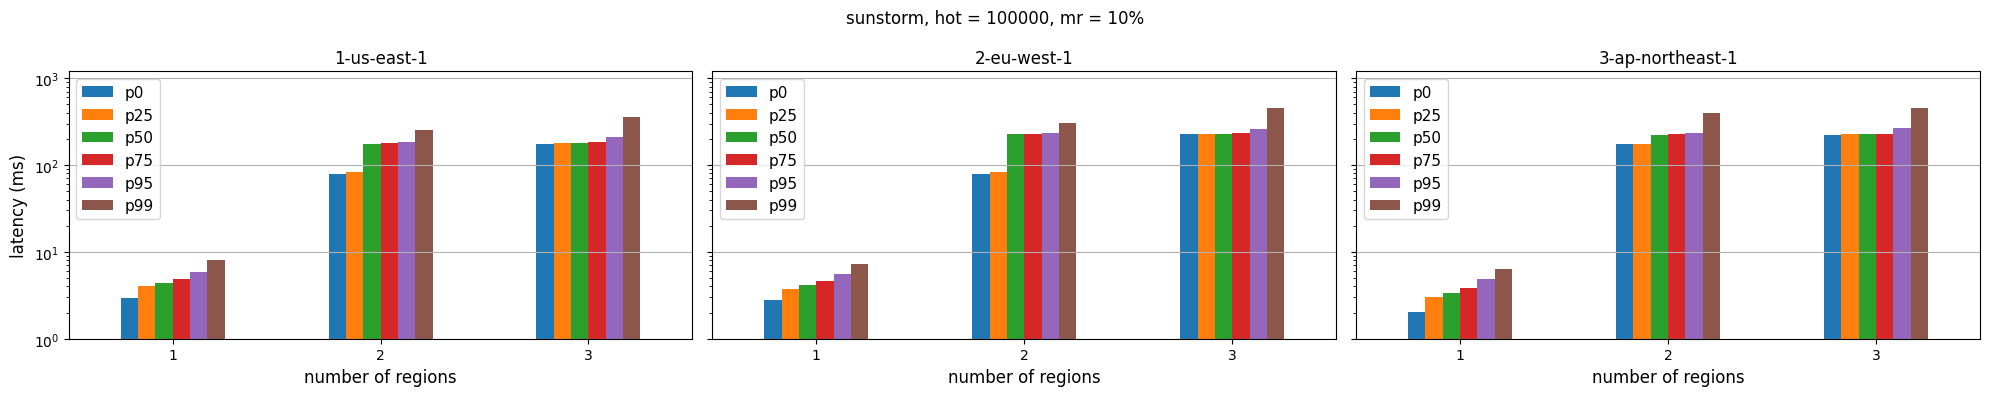

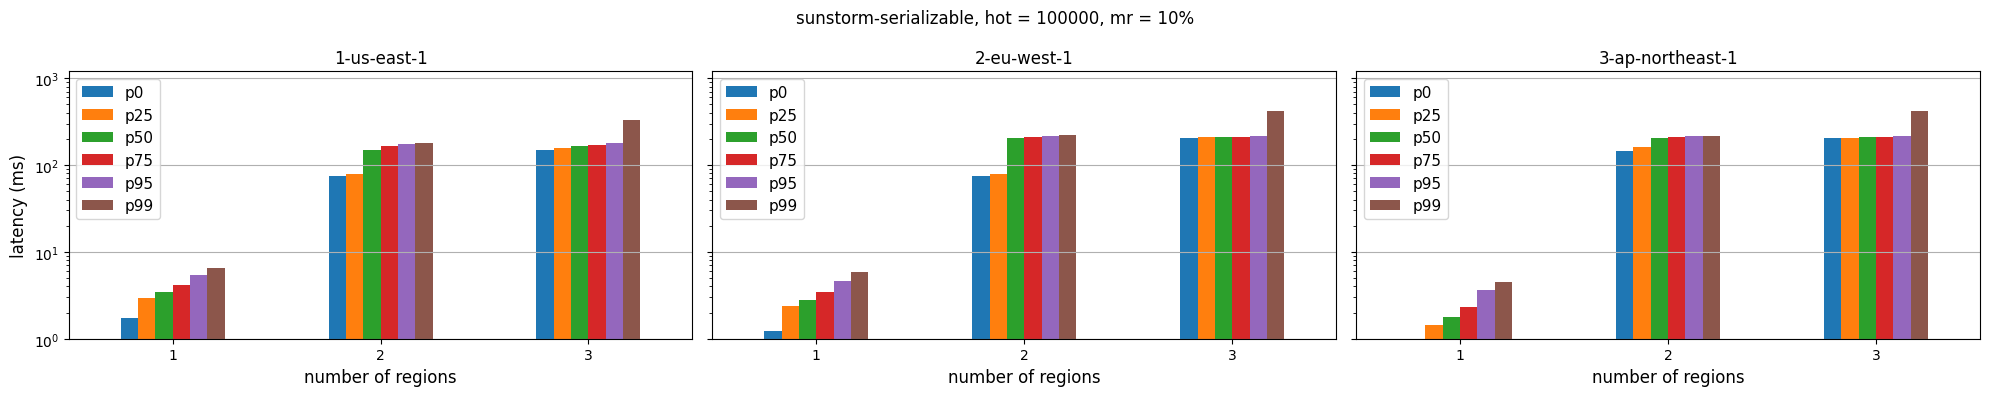

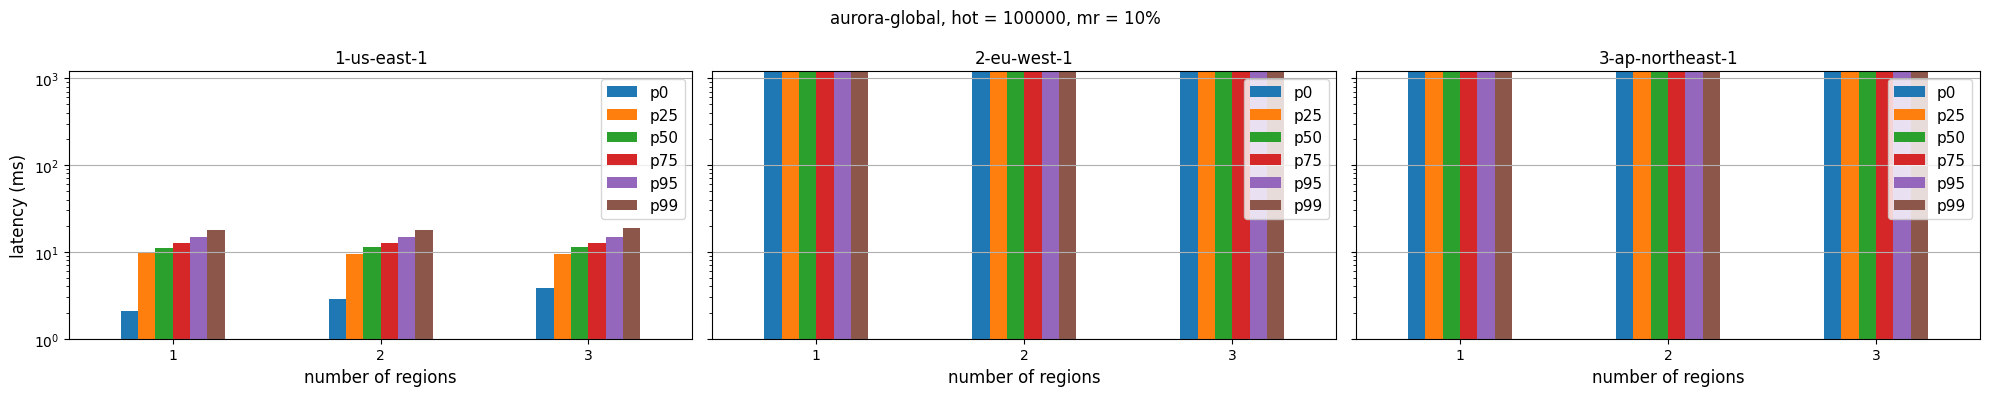

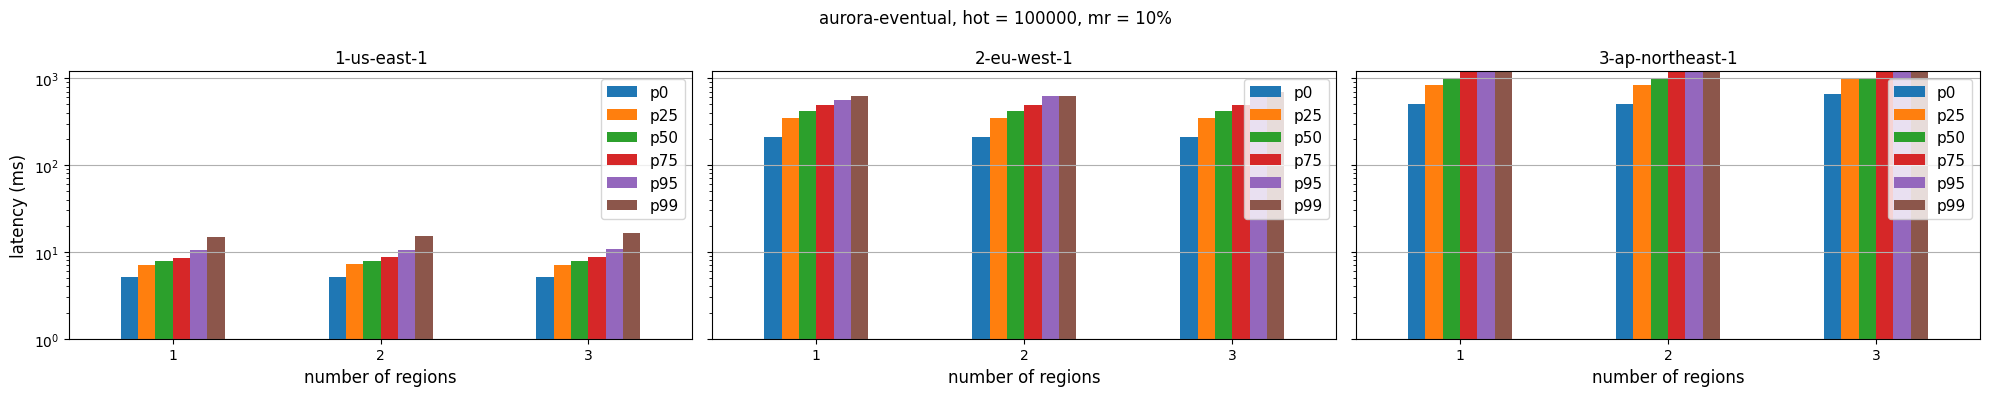

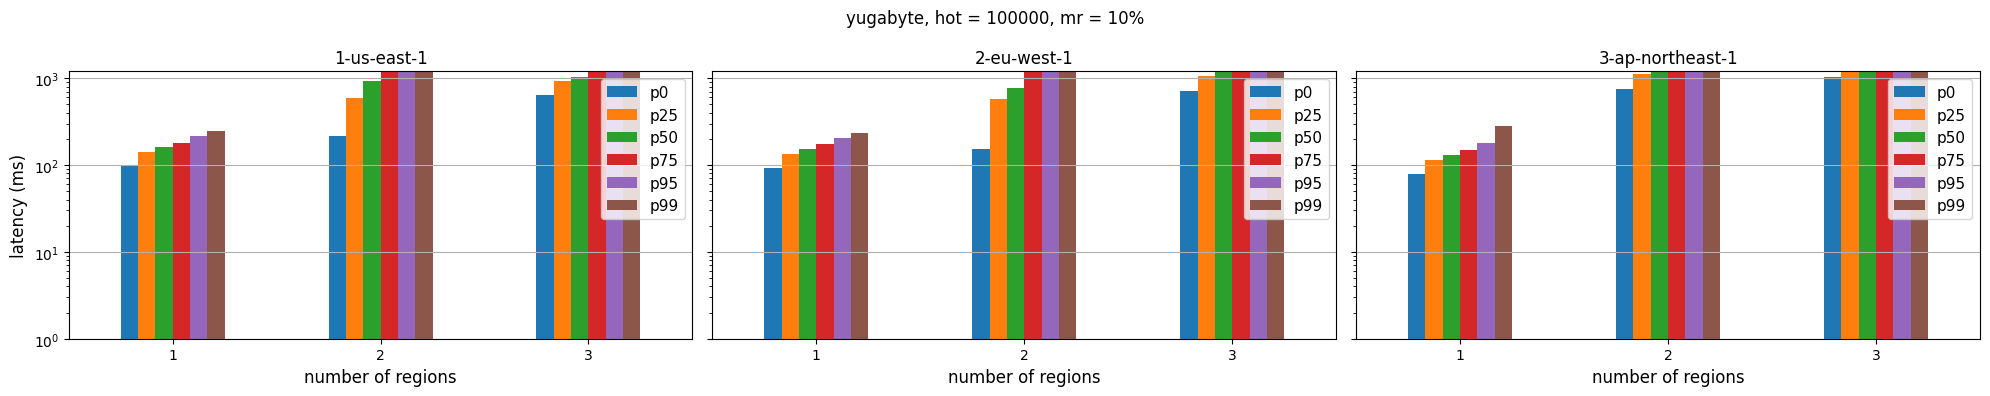

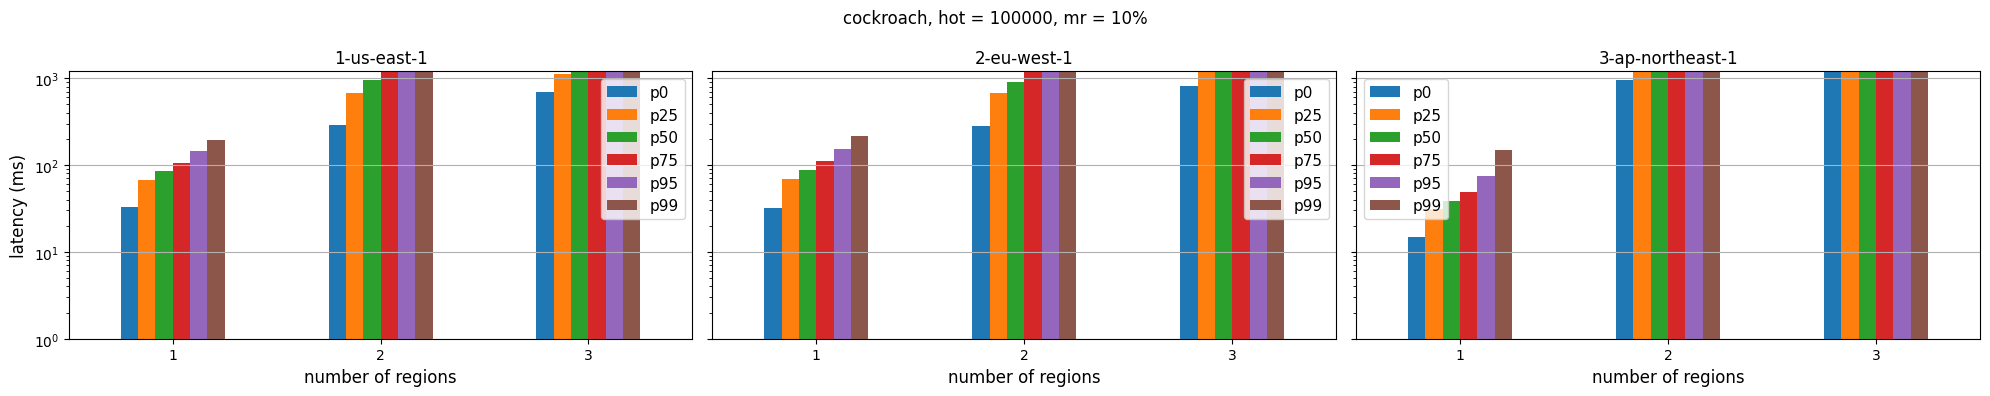

In [38]:
plot_latency(10, 100000)

/opt/homebrew/lib/python3.11/site-packages/pandas/plotting/_matplotlib/tools.py:318: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for t in axis.get_majorticklabels():


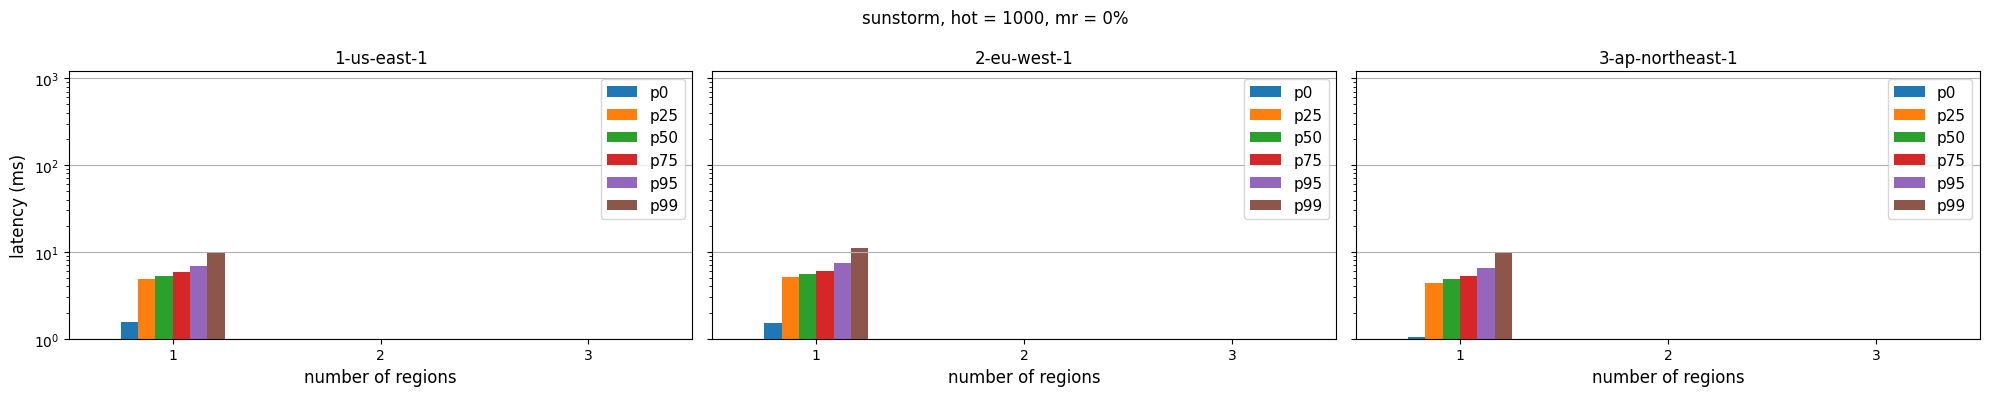

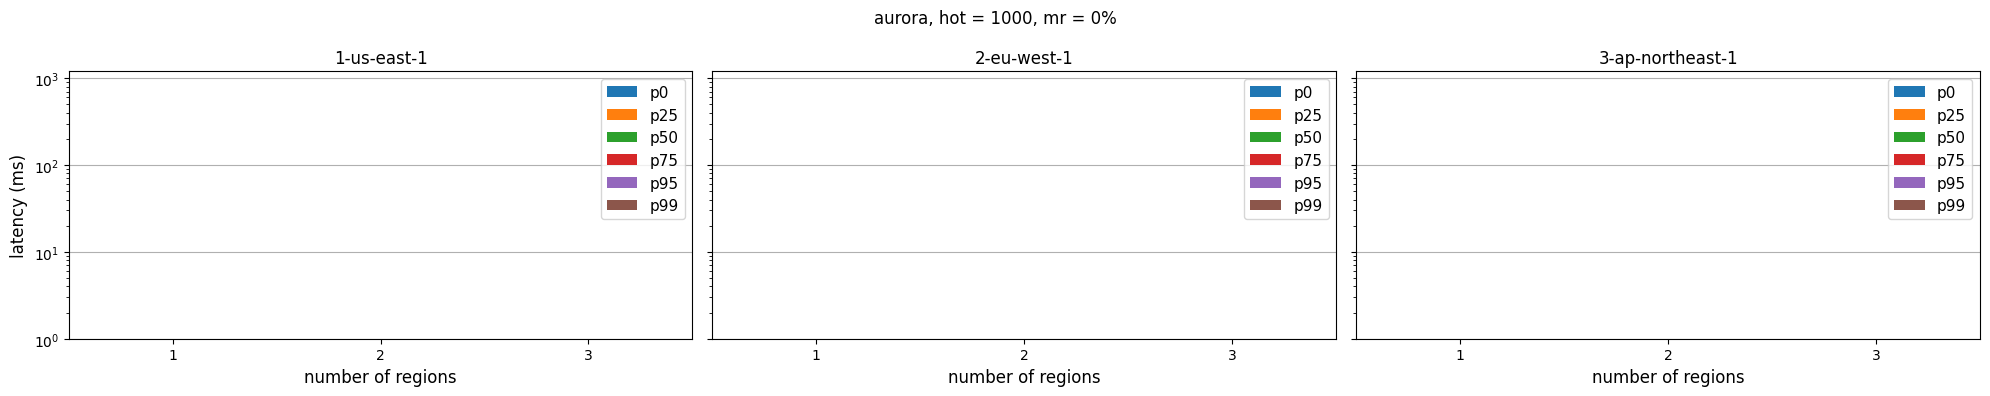

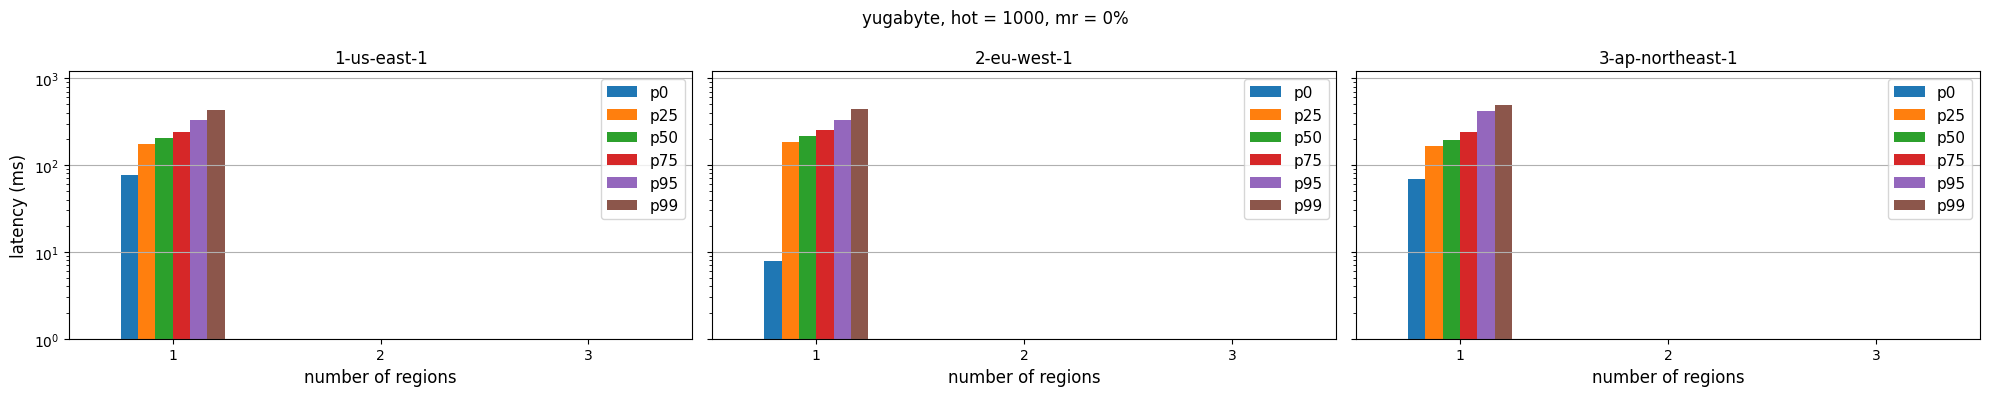

In [29]:
plot_latency(0, 1000)

/opt/homebrew/lib/python3.11/site-packages/pandas/plotting/_matplotlib/tools.py:318: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for t in axis.get_majorticklabels():


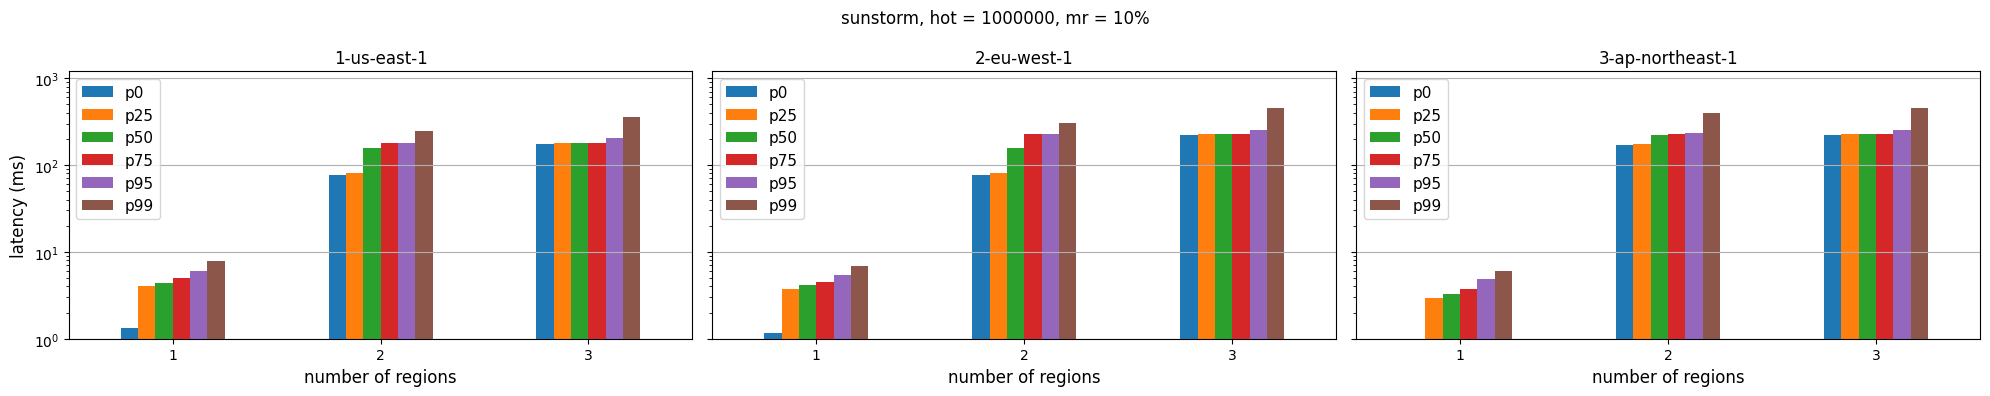

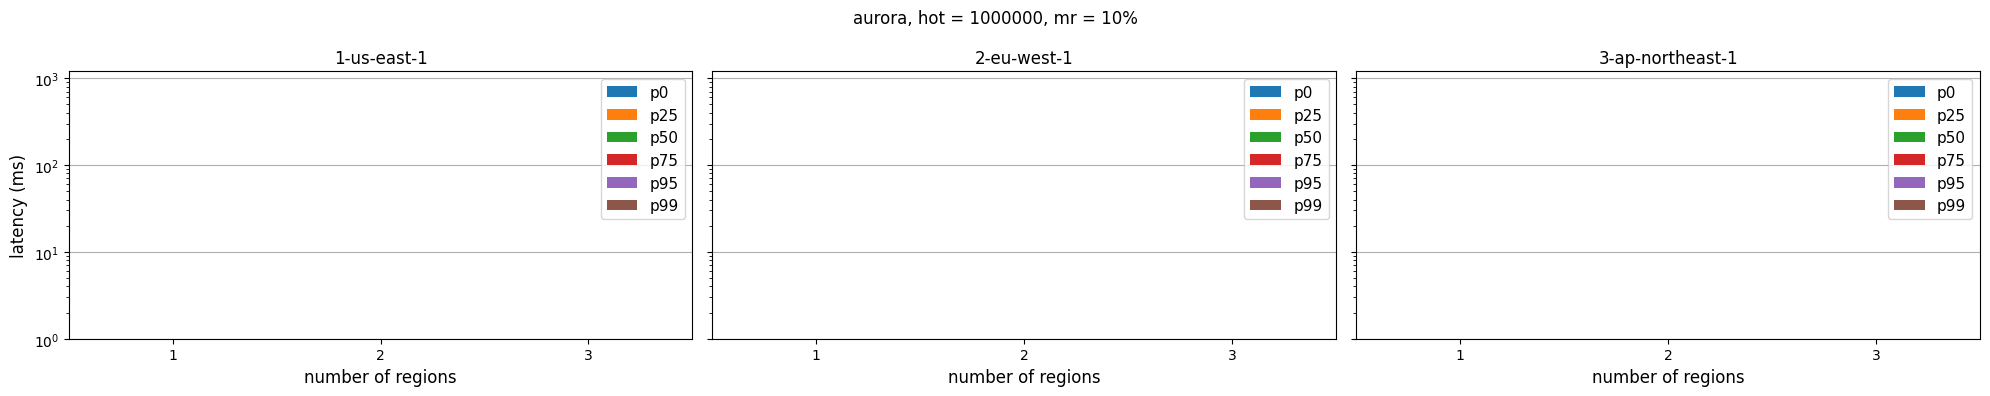

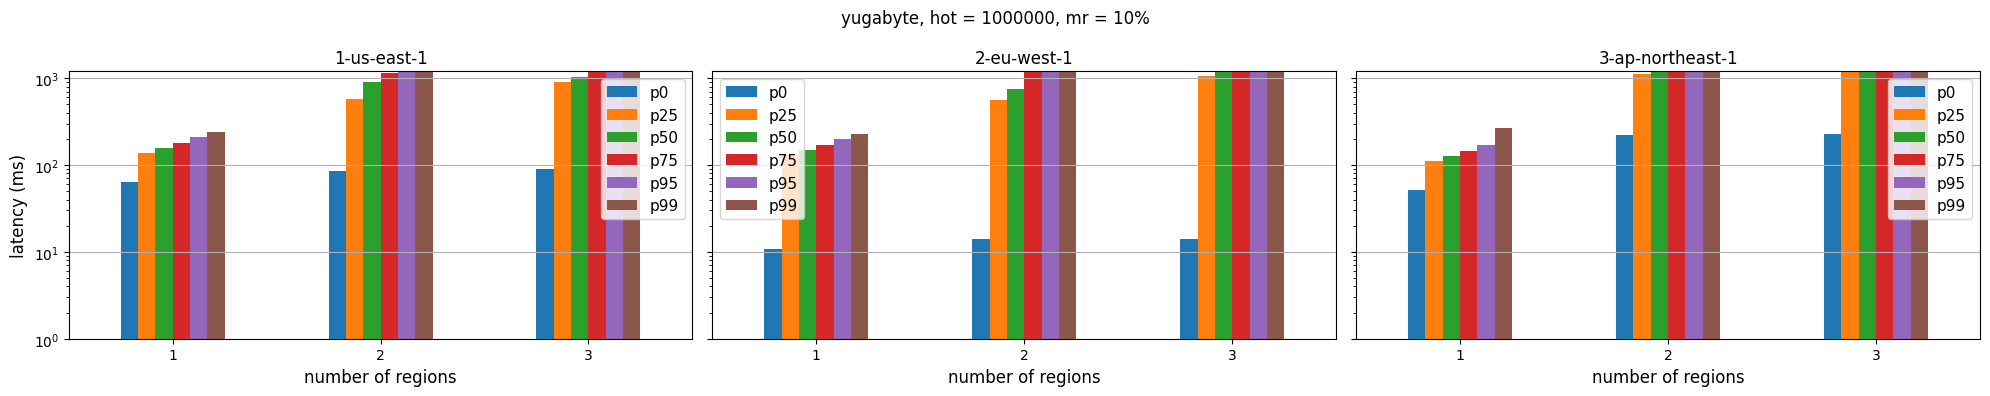

In [30]:
plot_latency(10, 1000000)

/opt/homebrew/lib/python3.11/site-packages/pandas/plotting/_matplotlib/tools.py:318: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for t in axis.get_majorticklabels():


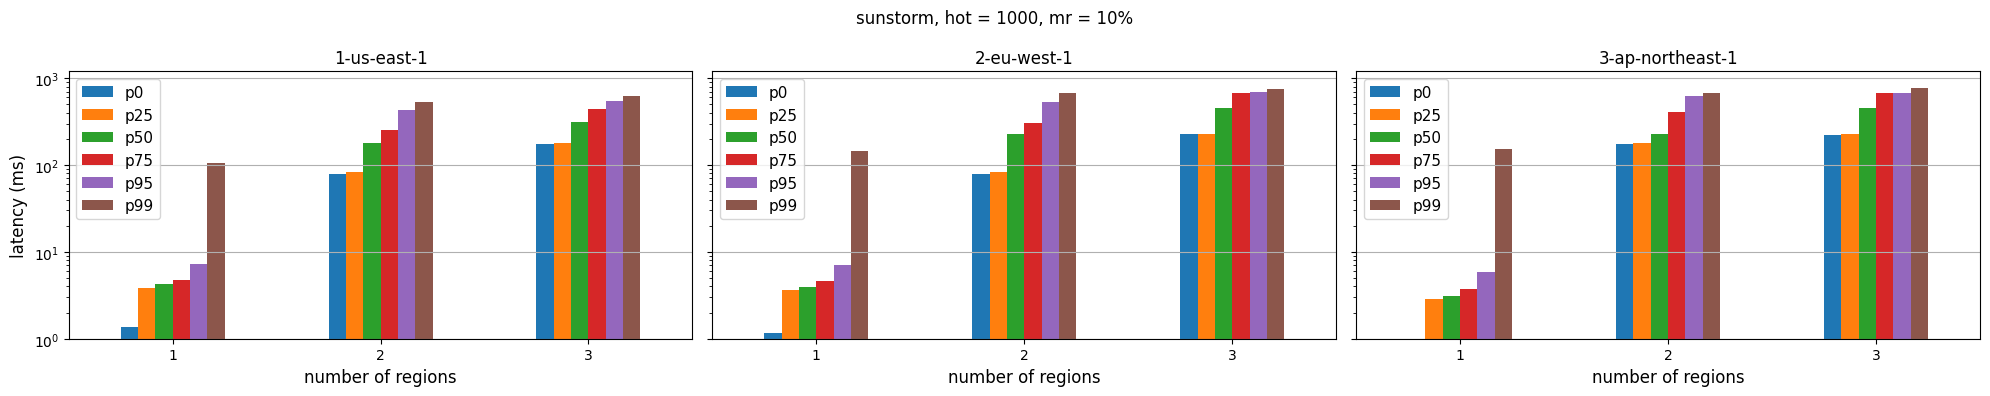

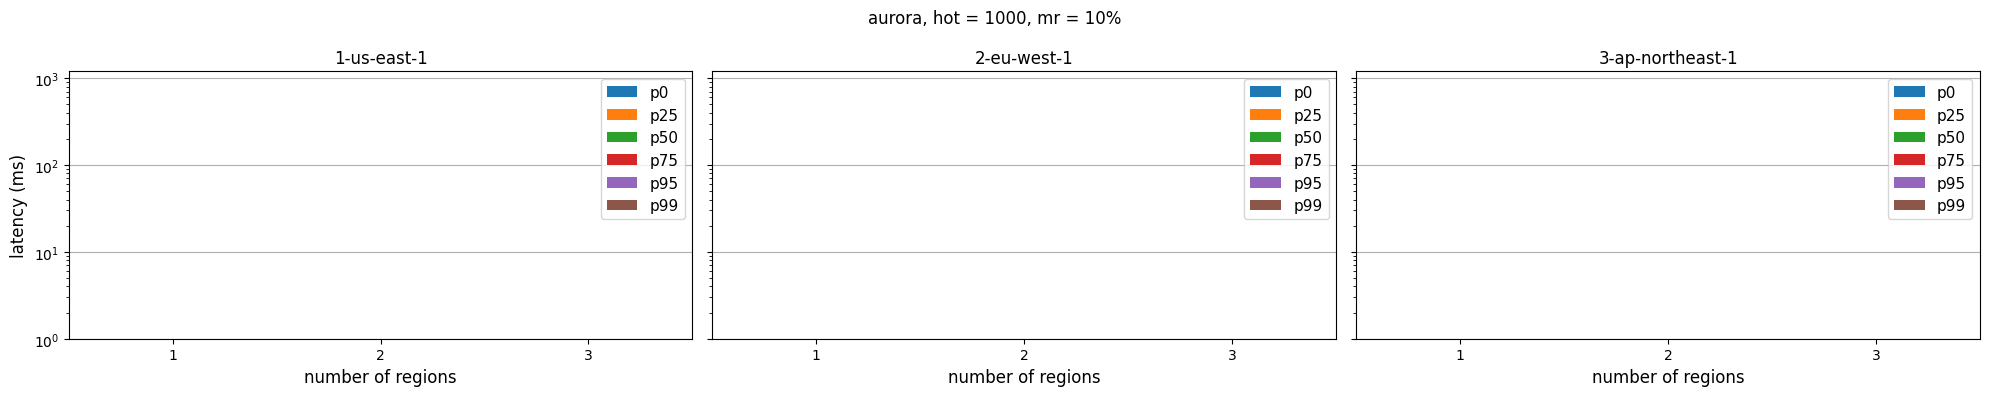

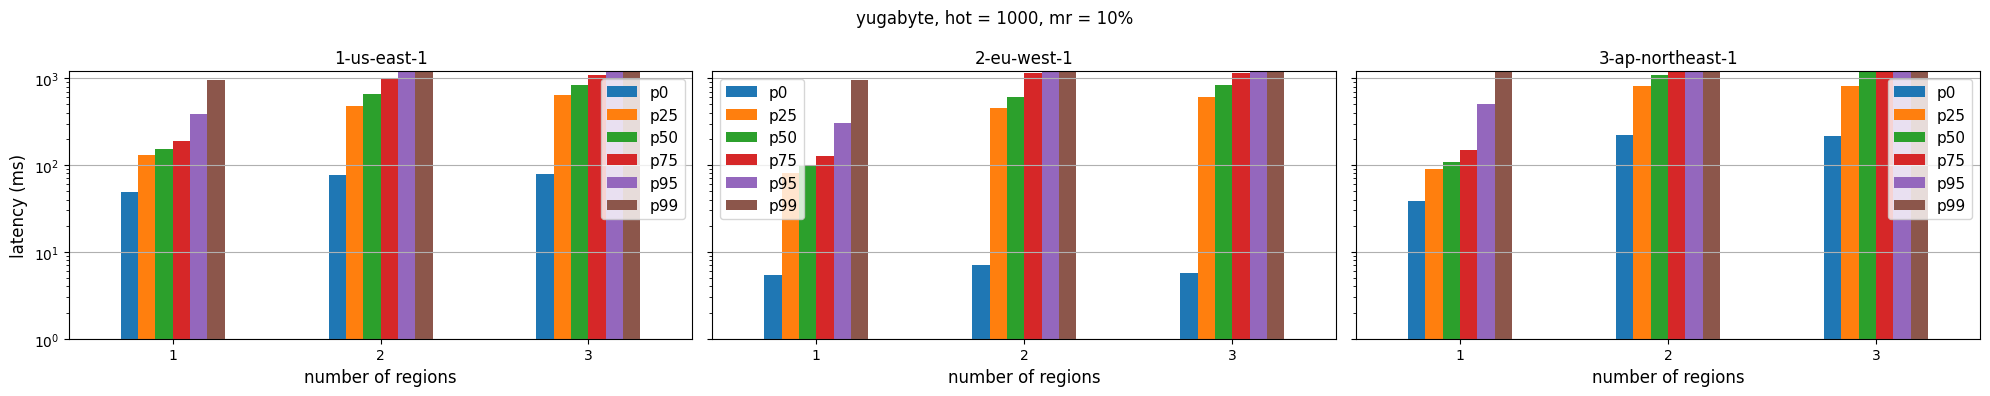

In [31]:
plot_latency(10, 1000)

/opt/homebrew/lib/python3.11/site-packages/pandas/plotting/_matplotlib/tools.py:318: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for t in axis.get_majorticklabels():


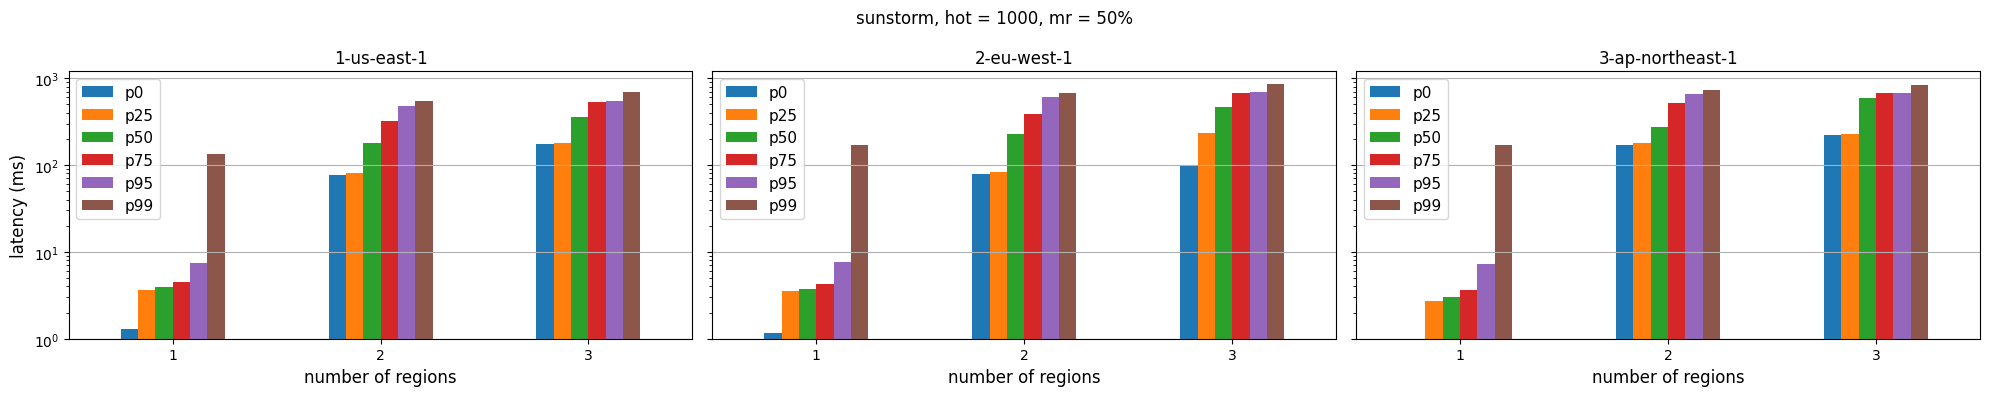

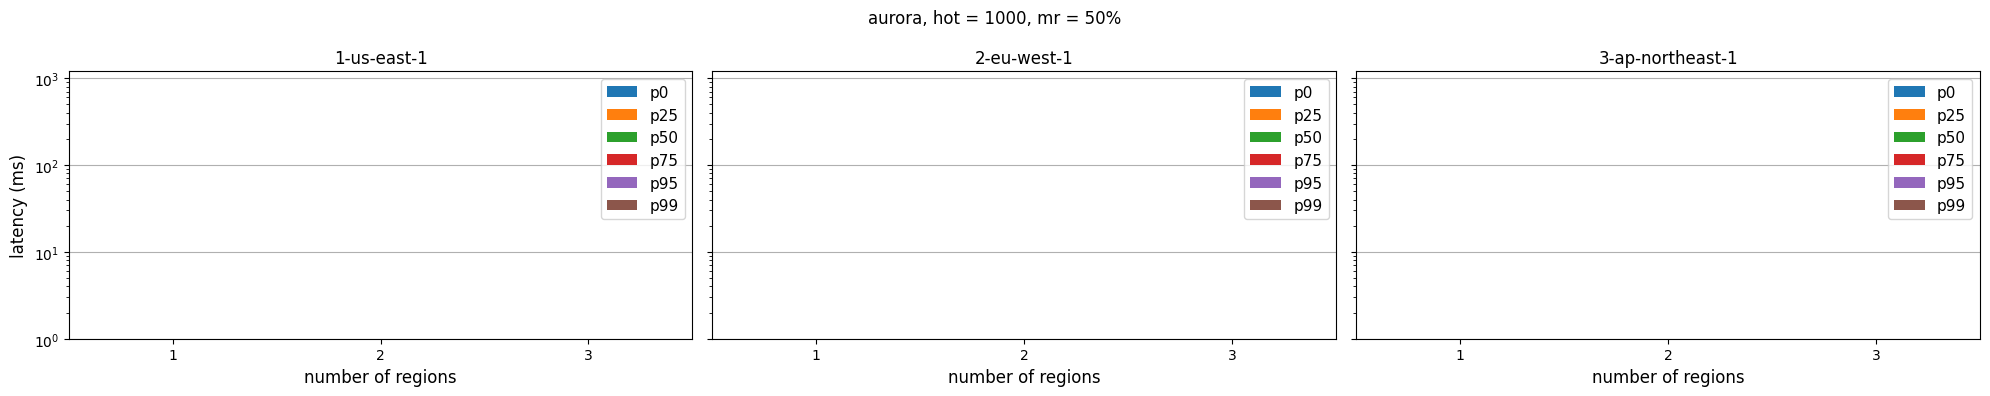

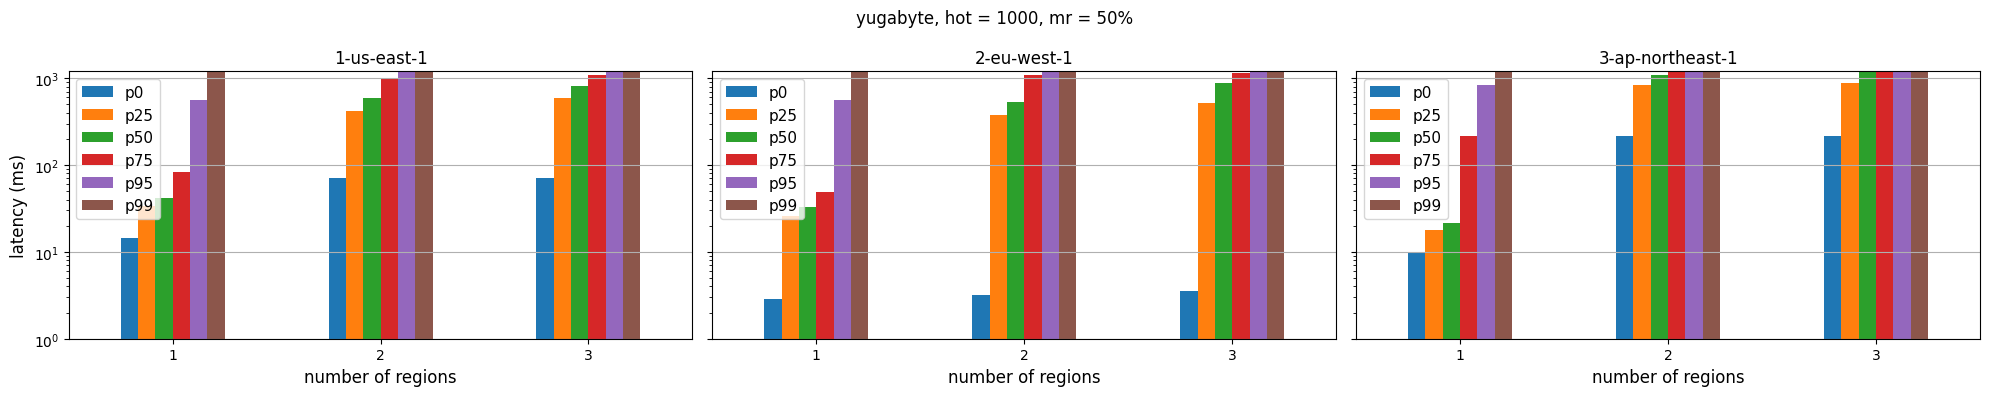

In [32]:
plot_latency(50, 1000)

In [251]:
yugabyte_throughput_df[(yugabyte_throughput_df.mr==0) & (yugabyte_throughput_df.region=='2-eu-west-1-0') & (yugabyte_throughput_df.hot==100000)]

,path,region,hot,workload,mr,suffix,rejected,rejected.WorkloadF1,rejected.WorkloadF2,rejected.WorkloadF3,...,avg.WorkloadF3,p0.WorkloadF3,p25.WorkloadF3,p50.WorkloadF3,p75.WorkloadF3,p90.WorkloadF3,p95.WorkloadF3,p99.WorkloadF3,p100.WorkloadF3,system
52,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,2-eu-west-1-0,100000,F,0,20240501-110250,2689,2689,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yugabyte


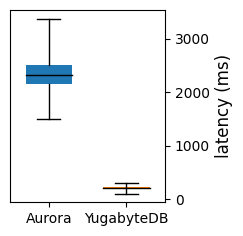

In [254]:
fig, ax = plt.subplots(figsize=(2, 2.5))

medianprops = dict(linestyle='-', linewidth=1, color='black')


aurora_eu_df = aurora_throughput_df[(aurora_throughput_df.mr==0) & (aurora_throughput_df.region=='2-eu-west-1-0') & (aurora_throughput_df.hot==100000)]
ax.bxp(
    [to_box(aurora_eu_df, 1)],
    positions=[0],
    patch_artist=True,
    widths=0.6,
    boxprops={
        "facecolor": "C0",
        "linewidth": 0,
    },
    medianprops=medianprops,
)

yugabyte_eu_df = yugabyte_throughput_df[(yugabyte_throughput_df.mr==0) & (yugabyte_throughput_df.region=='2-eu-west-1-0') & (yugabyte_throughput_df.hot==100000)]
ax.bxp(
    [to_box(yugabyte_eu_df, 1)],
    positions=[1],
    patch_artist=True,
    widths=0.6,
    boxprops={
        "facecolor": "C1",
        "linewidth": 0,
    },
    medianprops=medianprops,
)

ax.set_ylabel('latency (ms)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xticklabels(["Aurora", "YugabyteDB"])
plt.savefig('intro-latency.pdf', bbox_inches='tight')

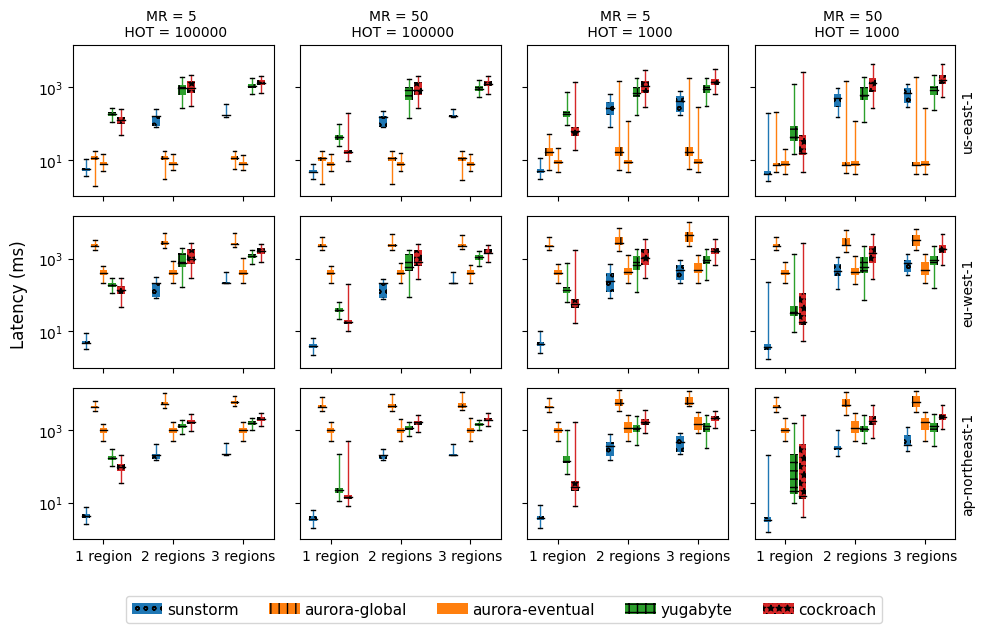

In [115]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 4, figure=fig)

plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

labels = [
    "1 region\n",
    "2 regions\n",
    "3 regions\n",
]
ticks = np.arange(len(labels))

width = 0.5

def to_box(df, n):
    return {
        'whislo': df[f"p0.WorkloadF{n}"].iloc[0],
        'q1': df[f"p25.WorkloadF{n}"].iloc[0],
        'med': df[f"p50.WorkloadF{n}"].iloc[0],
        'q3': df[f"p75.WorkloadF{n}"].iloc[0],
        'whishi': df[f"p99.WorkloadF{n}"].iloc[0],
        'fliers': []
    }


legends = []
patterns = [ "oo", "||", "", "++", "**"]
colors = ["C0", "C1", "C1", "C2", "C3"]

for m, mr in enumerate([5, 50]):
    for h, hot in enumerate([100000, 1000]):
        hot_df = throughput_df[throughput_df.hot == hot]
        hot_label = hot
        for r, region in enumerate(["1-us-east-1", "2-eu-west-1", "3-ap-northeast-1"]):
            region_df = hot_df[hot_df.region.str.startswith(region)]

            ax = plt.subplot(gs[r, (2*h) + m])
            for i, system in enumerate(SYSTEMS):
                system_df = region_df[region_df.system == system]
                boxes = [
                    to_box(system_df[system_df.mr == mr], 1),
                    to_box(system_df[system_df.mr == mr], 2),
                    to_box(system_df[system_df.mr == mr], 3),
                ]
                comps = ax.bxp(
                    boxes,
                    positions=ticks - width / 2 + i * width / (len(SYSTEMS) - 1),
                    showfliers=False,
                    manage_ticks=False,
                    patch_artist=True,
                    widths=0.11,
                    boxprops={
                        "facecolor": colors[i],
                        "linewidth": 0,
                        "hatch": patterns[i],
                    },
                    medianprops={
                        "color": "black",
                        "linewidth": 1,
                    },
                    whiskerprops={
                        "color": colors[i]
                    },
                )
                if (m==0 and h==0 and r==0):
                    legends.append(comps["boxes"][0])
                # legends.append(comps["boxes"][0])

            # ax.legend(legends, SYSTEMS, ncol=3)


            ax.set_yscale("log")
            ax.set_ylim(0.99, 15000)
            # ax.set_ylabel("latency (ms)")
            # ax.grid()
            if h == 1 and m == 1:
                ax.set_ylabel(region[2:], fontsize=10)
                ax.yaxis.set_label_position("right")
            if r == 2:
                ax.set_xticks(labels=labels, ticks=ticks)
            else:
                ax.set_xticks(labels=[], ticks=ticks)
         
            if r == 0:
                ax.set_title(f"MR = {mr} \n HOT = {hot_label}", fontsize=10)
                #ax.yaxis.set_label_position("right")
            # elif r == 0:
            #     ax.set_ylabel("")
            # else:
            #     ax.set_yticklabels([])
            # ax.set_title(f"HOT = {hot_label} ({region[2:]})")
            if h == 0 and m == 0:
                ax.set_ylabel("")
            else:
                ax.set_yticklabels([])

fig.legend(legends, SYSTEMS, ncol=5, bbox_to_anchor=(0.9, 0.01), handletextpad=0.3)
fig.supylabel("Latency (ms)")
fig.tight_layout()
fig.savefig("ycsb-latency-multiple.pdf", bbox_inches="tight")
